# **Used Car Price Predictor**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os 
import kaggle
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from zlib import crc32
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
import joblib

# **Import data from Kaggle**

We are using the "US Used cars dataset" from "https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset/data"

In [3]:
kaggleDataset = "ananaymital/us-used-cars-dataset"
datasetPath = os.path.join("dataset", "Used Cars")

In [4]:
# Check if the dataset folder already exists
if os.path.exists(datasetPath):
    download = input("The dataset may already be downloaded. Do you want to download and replace it? (Y/N): ").strip().upper()
    if download == 'Y':
        kaggle.api.dataset_download_files(kaggleDataset, datasetPath, unzip=True)
        print("Dataset downloaded and unzipped.")
    else:
        print("Skipping download.")
else:
    # Download if the dataset folder doesn't exist
    kaggle.api.dataset_download_files(kaggleDataset, datasetPath, unzip=True)
    print("Dataset downloaded and unzipped.")

Skipping download.


In [5]:
def loadCarData(datasetPath = datasetPath):
    csvPath = os.path.join(datasetPath, "used_cars_data.csv")
    return pd.read_csv(csvPath, nrows=400000, engine='python', on_bad_lines='skip')

# **Examine quick info about the data structure**

In [6]:
carsFullLoad = loadCarData()
carsFullLoad = carsFullLoad[carsFullLoad["price"] > 0]
carsFullLoad.head()

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,ZACNJABB5KPJ92081,35.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bayamon,NaN,NaN,...,A,9-Speed Automatic Overdrive,t83804,Latitude FWD,NaN,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,SALCJ2FX1LH858117,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,JF1VA2M67G9829723,35.4 in,NaN,NaN,NaN,Sedan,NaN,Guaynabo,17.0,NaN,...,M,6-Speed Manual,t58994,Base,NaN,AWD,All-Wheel Drive,104.3 in,78.9 in,2016
3,SALRR2RV0L2433391,37.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,NaN,AWD,All-Wheel Drive,115 in,87.4 in,2020
4,SALCJ2FXXLH862327,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020


In [7]:
carsFullLoad["make_name"].unique()

array(['Jeep', 'Land Rover', 'Subaru', 'Mazda', 'Alfa Romeo', 'BMW',
       'Hyundai', 'Chevrolet', 'Lexus', 'Cadillac', 'Chrysler', 'Dodge',
       'Mercedes-Benz', 'Nissan', 'Honda', 'Kia', 'Ford', 'Lincoln',
       'Audi', 'Jaguar', 'Volkswagen', 'RAM', 'Porsche', 'Toyota',
       'INFINITI', 'GMC', 'Acura', 'Maserati', 'FIAT', 'Volvo',
       'Mitsubishi', 'Buick', 'Mercury', 'Scion', 'Saab', 'MINI',
       'Ferrari', 'Genesis', 'Saturn', 'Bentley', 'Suzuki', 'Tesla',
       'Fisker', 'Pontiac', 'Lamborghini', 'smart', 'Hummer',
       'Rolls-Royce', 'Lotus', 'Spyker', 'McLaren', 'Aston Martin',
       'Kaiser', 'Oldsmobile', 'Maybach', 'Freightliner', 'Karma',
       'Isuzu', 'Plymouth', 'Shelby', 'Triumph', 'MG', 'Pagani', 'Datsun',
       'Studebaker', 'AM General', 'Austin-Healey', 'AMC', 'Hudson',
       'Willys'], dtype=object)

To avoid outliers and keep the project more simple, let's only limit the makes of the car to below, which are common US car makes.

In [8]:
make_names = [
    "Jeep", "Chevrolet", "Cadillac", "Chrysler", "Dodge", "Ford", 
    "Lincoln", "RAM", "GMC", "Buick", "Tesla", "Hummer"
]

carsLoad = carsFullLoad[carsFullLoad["make_name"].isin(make_names)]

In [9]:
carsLoad["make_name"].unique()

array(['Jeep', 'Chevrolet', 'Cadillac', 'Chrysler', 'Dodge', 'Ford',
       'Lincoln', 'RAM', 'GMC', 'Buick', 'Tesla', 'Hummer'], dtype=object)

# **Initial information of our dataset**

In [10]:
carsLoad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185479 entries, 0 to 399997
Data columns (total 66 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   vin                      185479 non-null  object 
 1   back_legroom             177198 non-null  object 
 2   bed                      2147 non-null    object 
 3   bed_height               40526 non-null   object 
 4   bed_length               40526 non-null   object 
 5   body_type                185200 non-null  object 
 6   cabin                    6319 non-null    object 
 7   city                     185479 non-null  object 
 8   city_fuel_economy        150108 non-null  float64
 9   combine_fuel_economy     0 non-null       float64
 10  daysonmarket             185479 non-null  int64  
 11  dealer_zip               185479 non-null  object 
 12  description              176744 non-null  object 
 13  engine_cylinders         179748 non-null  object 
 14  engine_di

In [11]:
carsLoad.describe()

,city_fuel_economy,combine_fuel_economy,daysonmarket,engine_displacement,highway_fuel_economy,horsepower,is_certified,latitude,listing_id,longitude,mileage,owner_count,price,savings_amount,seller_rating,sp_id,vehicle_damage_category,year
count,150108.000000,0.0,185479.000000,176471.000000,150108.000000,176471.000000,0.0,185479.000000,1.854790e+05,185479.000000,1.759000e+05,87375.000000,1.854790e+05,185479.000000,183147.000000,185455.000000,0.0,185479.000000
mean,20.208350,NaN,86.351317,3258.052598,26.774516,272.608293,NaN,41.580310,2.745826e+08,-77.310391,2.941282e+04,1.479348,3.138161e+04,553.901110,4.263669,225421.276110,NaN,2017.718308
std,7.493477,NaN,119.229958,1494.397263,6.542663,89.037421,NaN,1.580706,9.762050e+06,6.388532,4.443715e+04,0.857365,1.700082e+04,989.728469,0.534769,129696.682299,NaN,4.235466
min,8.000000,NaN,0.000000,1000.000000,11.000000,84.000000,NaN,18.398800,5.663194e+07,-157.902000,0.000000e+00,1.000000,2.990000e+02,0.000000,1.000000,41593.000000,NaN,1915.000000
25%,17.000000,NaN,17.000000,2000.000000,23.000000,180.000000,NaN,40.713500,2.735832e+08,-83.284100,5.000000e+00,1.000000,1.998700e+04,0.000000,4.000000,61395.000000,NaN,2017.000000
50%,19.000000,NaN,40.000000,3200.000000,26.000000,281.000000,NaN,41.748500,2.780400e+08,-74.500400,5.273500e+03,1.000000,2.927000e+04,0.000000,4.333333,276905.000000,NaN,2020.000000
75%,22.000000,NaN,94.000000,3600.000000,29.000000,341.000000,NaN,42.561600,2.801435e+08,-72.540400,4.225825e+04,2.000000,4.096700e+04,796.000000,4.619048,326001.000000,NaN,2020.000000
max,127.000000,NaN,2716.000000,8400.000000,127.000000,808.000000,NaN,61.203100,2.817029e+08,-66.158200,4.290461e+06,15.000000,2.698500e+06,20839.000000,5.000000,440798.000000,NaN,2021.000000


# **Cleaning Our Data**

Let's make our dataset only with the columns that are not filled with many null values, and if it is a bit, we can replace the few null values with "No Input".

We will also convert some obvious numeric objects and dates to float types.

In [12]:
cars = carsLoad.loc[:, ["body_type", "daysonmarket", "engine_displacement", "engine_type", "franchise_dealer", "fuel_type", "horsepower", "is_new", "latitude", "listed_date", "listing_color", "listing_id", "longitude", "make_name", "model_name", "mileage", "price", "savings_amount", "seller_rating", "transmission", "trim_name", "wheel_system", "year"]]

for col in ['body_type', 'engine_type', 'fuel_type', 'transmission', "trim_name", 'wheel_system']:
    cars[col] = cars[col].fillna('No Input').str.lower()


for col in ['front_legroom', 'maximum_seating']:
    cars[col] = carsLoad[col].str.extract(r'(\d+(?:\.\d+)?)').astype(float)
    
cars['listed_dateTEMP'] = pd.to_datetime(carsLoad['listed_date']) 
cars['listed_date'] = cars['listed_dateTEMP'].astype('int64') / 1e9
cars.drop('listed_dateTEMP', axis=1, inplace=True)

In [13]:
cars.head()

,body_type,daysonmarket,engine_displacement,engine_type,franchise_dealer,fuel_type,horsepower,is_new,latitude,listed_date,...,mileage,price,savings_amount,seller_rating,transmission,trim_name,wheel_system,year,front_legroom,maximum_seating
0,suv / crossover,522,1300.0,i4,True,gasoline,177.0,True,18.3988,1.554509e+09,...,7.0,23141.0,0,2.800000,a,latitude fwd,fwd,2019,41.2,5.0
27,suv / crossover,522,1300.0,i4,True,gasoline,177.0,True,18.3988,1.554509e+09,...,20.0,27587.0,0,2.800000,a,latitude 4wd,4wd,2019,41.2,5.0
33,suv / crossover,522,1300.0,i4,True,gasoline,177.0,True,18.3988,1.554509e+09,...,7.0,27587.0,0,2.800000,a,latitude 4wd,4wd,2019,41.2,5.0
38,sedan,55,1500.0,i4,True,gasoline,160.0,False,40.7333,1.594858e+09,...,42394.0,14639.0,1749,3.447761,a,lt fwd,fwd,2018,42.0,5.0
41,suv / crossover,27,3600.0,v6,True,gasoline,310.0,False,40.7333,1.597277e+09,...,36410.0,23723.0,3500,3.447761,a,lt cloth fwd,fwd,2018,41.0,8.0


In [14]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185479 entries, 0 to 399997
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   body_type            185479 non-null  object 
 1   daysonmarket         185479 non-null  int64  
 2   engine_displacement  176471 non-null  float64
 3   engine_type          185479 non-null  object 
 4   franchise_dealer     185479 non-null  bool   
 5   fuel_type            185479 non-null  object 
 6   horsepower           176471 non-null  float64
 7   is_new               185479 non-null  bool   
 8   latitude             185479 non-null  float64
 9   listed_date          185479 non-null  float64
 10  listing_color        185479 non-null  object 
 11  listing_id           185479 non-null  int64  
 12  longitude            185479 non-null  float64
 13  make_name            185479 non-null  object 
 14  model_name           185479 non-null  object 
 15  mileage              1

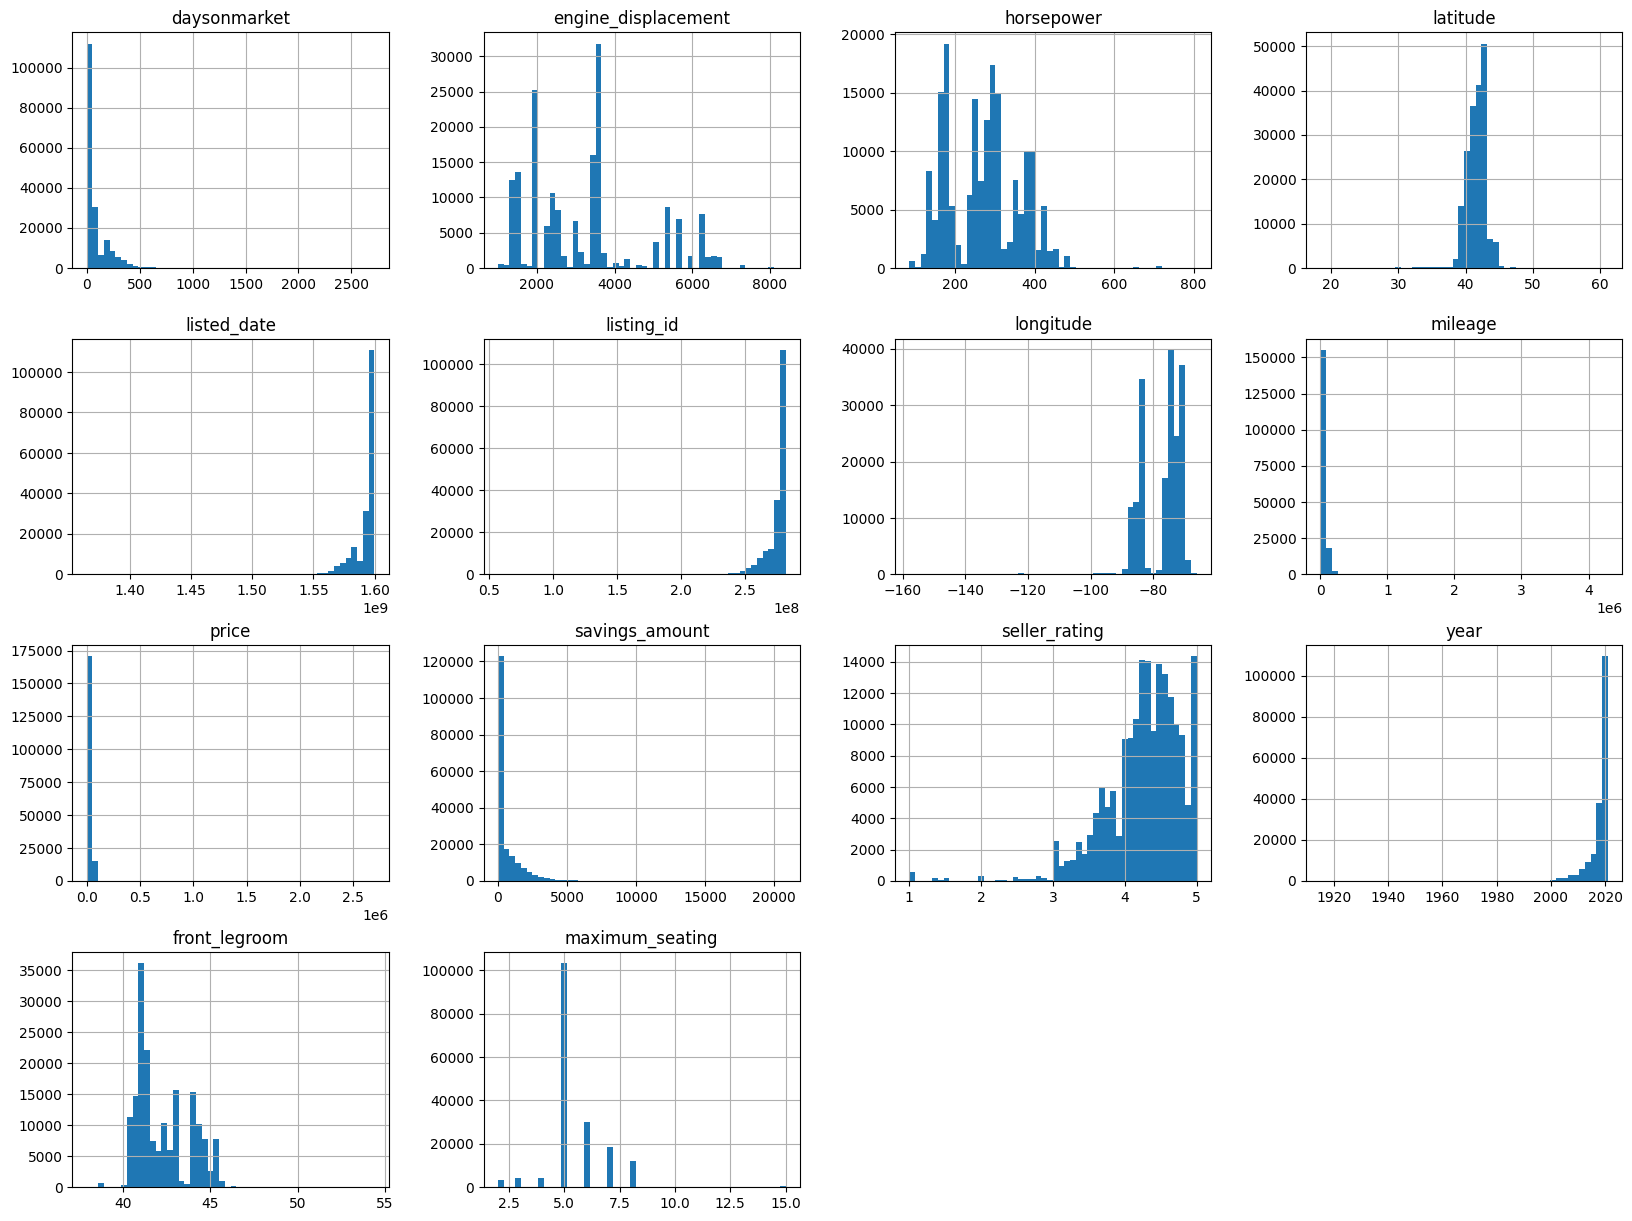

In [15]:
cars.hist(bins=50, figsize=(20,15))
plt.show()

Looking at some of these graphs, we can see some obvious unrealistic values that are skewing the graph. 

Let's find these outliers and filter them out.

In [16]:
max_daysonmarket = cars["daysonmarket"].max()
min_listed_date = cars["listed_date"].min()
min_listing_id = cars["listing_id"].min()
max_mileage = cars["mileage"].max()
max_price = cars["price"].max()
max_savings_amount = cars["savings_amount"].max()
min_year = cars["year"].min()
max_maximum_seating = cars["maximum_seating"].max()

print("Maximum daysonmarket:", max_daysonmarket)
print("Minimum listed_date:", min_listed_date)
print("Minimum listing_id:", min_listing_id)
print("Maximum mileage:", max_mileage)
print("Maximum price:", max_price)
print("Maximum savings_amount:", max_savings_amount)
print("Minimum year:", min_year)
print("Maximum maximum_seating:", max_maximum_seating)

Maximum daysonmarket: 2716
Minimum listed_date: 1364947200.0
Minimum listing_id: 56631937
Maximum mileage: 4290461.0
Maximum price: 2698500.0
Maximum savings_amount: 20839
Minimum year: 1915
Maximum maximum_seating: 15.0


In [17]:
cars = cars[(cars["daysonmarket"] <= 1000) & 
            (cars["listed_date"] >= 1500000000.0) & 
            (cars["listing_id"] >= 200000000) & 
            (cars["mileage"] <= 1000000) &
            (cars["price"] <= 300000) &
            (cars["savings_amount"] <= 20000) & 
            (cars["year"] >= 1990) & 
            (cars["maximum_seating"] <= 11)]

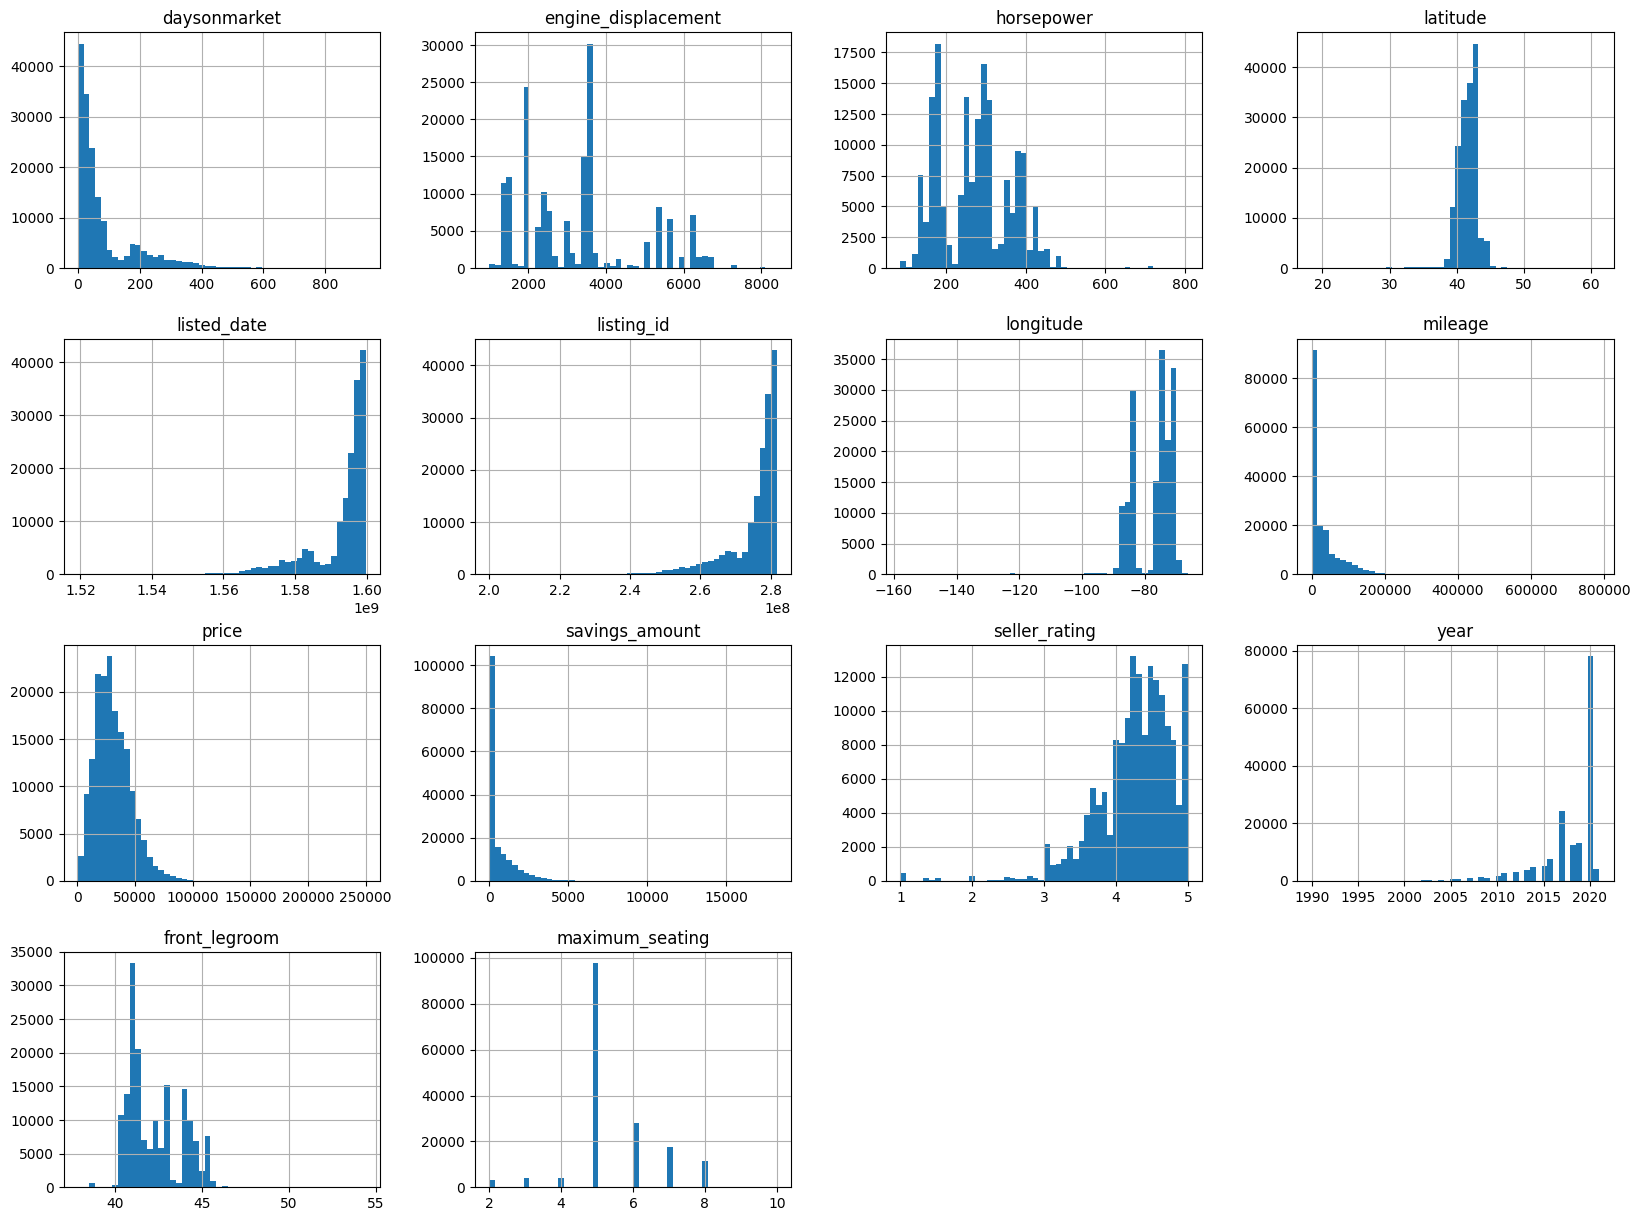

In [18]:
cars.hist(bins=50, figsize=(20,15))
plt.show()

In [19]:
max_daysonmarket = cars["daysonmarket"].max()
min_listed_date = cars["listed_date"].min()
min_listing_id = cars["listing_id"].min()
max_mileage = cars["mileage"].max()
max_price = cars["price"].max()
max_savings_amount = cars["savings_amount"].max()
min_year = cars["year"].min()
max_maximum_seating = cars["maximum_seating"].max()

print("Maximum daysonmarket:", max_daysonmarket)
print("Minimum listed_date:", min_listed_date)
print("Minimum listing_id:", min_listing_id)
print("Maximum mileage:", max_mileage)
print("Maximum price:", max_price)
print("Maximum savings_amount:", max_savings_amount)
print("Minimum year:", min_year)
print("Maximum maximum_seating:", max_maximum_seating)

Maximum daysonmarket: 931
Minimum listed_date: 1519344000.0
Minimum listing_id: 200021460
Maximum mileage: 785778.0
Maximum price: 249999.0
Maximum savings_amount: 18188
Minimum year: 1990
Maximum maximum_seating: 10.0


### Let's make a new column grouping `price`, this will come in handy later to ensure our test set is not running into sampling bias. 

In [20]:
cars["price_group"] = pd.cut(cars["price"],
                            bins=[0., 10000., 20000.,30000., 40000., 50000., np.inf],
                            labels=[1, 2, 3, 4, 5, 6])

<Axes: >

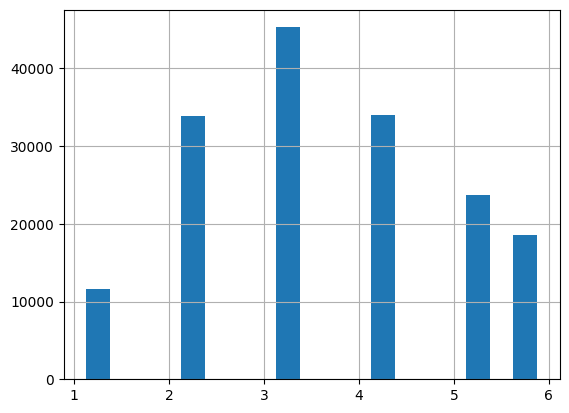

In [21]:
cars["price_group"].hist(rwidth=0.5)

In [22]:
cars["price_group"].value_counts() / len(cars)

price_group
3    0.270940
4    0.203458
2    0.202979
5    0.142225
6    0.111211
1    0.069188
Name: count, dtype: float64

# **Creating our Train and Test Set**

In order to ensure that our test set stays consistent no matter how many times we rerun the program or update the dataset, we want to use a unique identifier to help us decide if the row should go into the test set or not. We can compute a hash for each row's unique identifier and if it is less than or equal to 20% of the maximum hash value, it will go into the test set. 

In [23]:
cars = cars.drop_duplicates(subset="listing_id", keep="first")

In [24]:
len(cars) - len(cars["listing_id"].unique()) # Making sure "listing_id" is unique, this should be zero if true

0

In [25]:
def IDTest(ID, testRatio):
    return crc32(np.int64(ID)) & 0xffffffff < testRatio*2**32

def splitTrainTestByID(dataset,testRatio,ID):
    IDs = dataset[ID]
    testRows = IDs.apply(lambda ID_: IDTest(ID_, testRatio))
    return dataset.loc[~testRows], dataset.loc[testRows]

In [26]:
trainSet, testSet = splitTrainTestByID(cars, 0.2, "listing_id")

In [27]:
len(trainSet) / len(cars) # training set should be 80%

0.7983442281445299

In [28]:
len(testSet) / len(cars) # training set should be 20%

0.20165577185547015

Let's compare our test set's price group proportions to the overall price group proportions.

In [29]:
(testSet["price_group"].value_counts() / len(testSet)) - (cars["price_group"].value_counts() / len(cars))


price_group
1   -0.002901
2    0.001165
3    0.001955
4   -0.000234
5   -0.000301
6    0.000316
Name: count, dtype: float64

The proportions of the price groups in our test set are nearly identical to the overall proportions. 
Therefore, it is not necessary to try and do stratified sampling. 

We can now be confident that our test set is a good representation of the overall dataset.
We can remove the priceGroup column. 
We can also remove listing_id as we do not want the model to make predictions with it.

In [30]:
for set_ in (trainSet, testSet):
    set_.drop(columns=["price_group", "listing_id"], inplace=True)

# **Visualizing Data**
Now we can play with our train set, first let's start with visualizing the data

<Axes: xlabel='longitude', ylabel='latitude'>

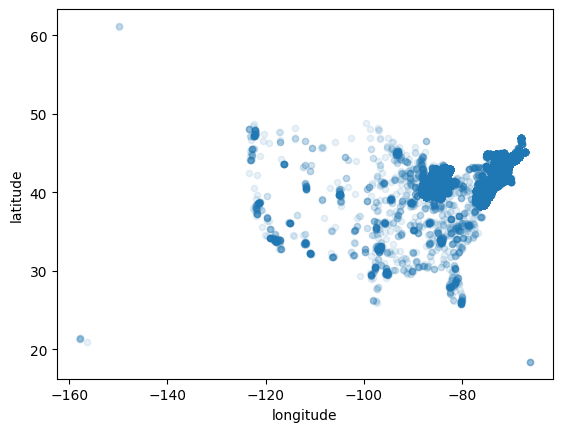

In [31]:
trainSet.plot.scatter(x="longitude", y="latitude", alpha=0.1)

<Axes: xlabel='mileage', ylabel='daysonmarket'>

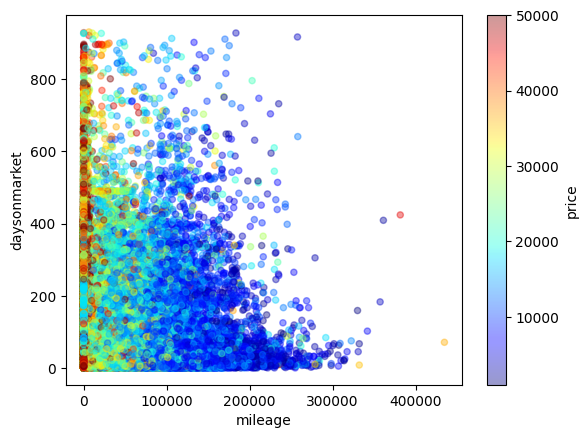

In [32]:
trainSet.plot.scatter(x="mileage", y="daysonmarket", alpha=0.4,
                  c="price", cmap=plt.get_cmap("jet"), colorbar=True,
                  vmin=1000, vmax=50000)

In [33]:
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133365 entries, 0 to 399993
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   body_type            133365 non-null  object 
 1   daysonmarket         133365 non-null  int64  
 2   engine_displacement  132554 non-null  float64
 3   engine_type          133365 non-null  object 
 4   franchise_dealer     133365 non-null  bool   
 5   fuel_type            133365 non-null  object 
 6   horsepower           132554 non-null  float64
 7   is_new               133365 non-null  bool   
 8   latitude             133365 non-null  float64
 9   listed_date          133365 non-null  float64
 10  listing_color        133365 non-null  object 
 11  longitude            133365 non-null  float64
 12  make_name            133365 non-null  object 
 13  model_name           133365 non-null  object 
 14  mileage              133365 non-null  float64
 15  price                1

Let's start looking at correlations and visualize it.

In [34]:
train_numeric_attribs = trainSet.select_dtypes(include=['float64', 'int64'])
corr_matrix = train_numeric_attribs.corr()

In [35]:
corr_matrix["price"].sort_values(ascending=False)

price                  1.000000
horsepower             0.617832
year                   0.578569
engine_displacement    0.402033
front_legroom          0.294748
maximum_seating        0.273038
daysonmarket           0.089151
longitude              0.082384
latitude               0.028781
seller_rating          0.023097
listed_date           -0.089771
savings_amount        -0.188785
mileage               -0.586963
Name: price, dtype: float64

array([[<Axes: xlabel='price', ylabel='price'>,
        <Axes: xlabel='horsepower', ylabel='price'>,
        <Axes: xlabel='year', ylabel='price'>,
        <Axes: xlabel='mileage', ylabel='price'>],
       [<Axes: xlabel='price', ylabel='horsepower'>,
        <Axes: xlabel='horsepower', ylabel='horsepower'>,
        <Axes: xlabel='year', ylabel='horsepower'>,
        <Axes: xlabel='mileage', ylabel='horsepower'>],
       [<Axes: xlabel='price', ylabel='year'>,
        <Axes: xlabel='horsepower', ylabel='year'>,
        <Axes: xlabel='year', ylabel='year'>,
        <Axes: xlabel='mileage', ylabel='year'>],
       [<Axes: xlabel='price', ylabel='mileage'>,
        <Axes: xlabel='horsepower', ylabel='mileage'>,
        <Axes: xlabel='year', ylabel='mileage'>,
        <Axes: xlabel='mileage', ylabel='mileage'>]], dtype=object)

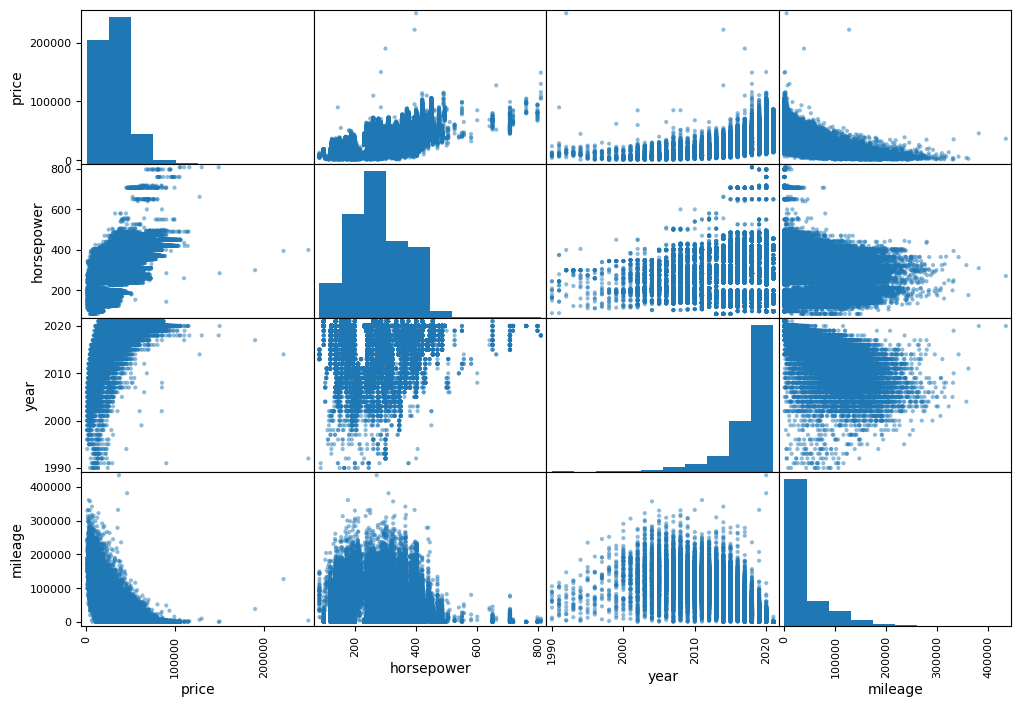

In [36]:
matrix_attributes = ["price", "horsepower", "year", "mileage"]
scatter_matrix(trainSet[matrix_attributes], figsize=(12,8))

# **Data Imputation**

For our transformation pipeline, we will need it to do some data imputation. Some of our float type columns still have some null values. We can replace all null values with the median of the attribute.

To be on the safer side, let's use Scikit-Learn's SimpleImputer class to replace all null values with the median to all numerical columns. Let's see how it will do before creating our pipeline.

In [37]:
X_train = trainSet.drop("price", axis=1)
y_train = trainSet["price"].copy()

In [38]:
X_train_numeric_attribs = X_train.select_dtypes(include=['float64', 'int64'])

imputer = SimpleImputer(strategy="median")
imputer.fit(X_train_numeric_attribs)

SimpleImputer(strategy='median')

In [39]:
imputer.statistics_

array([ 4.00000000e+01,  3.20000000e+03,  2.81000000e+02,  4.17182000e+01,
        1.59615360e+09, -7.44935000e+01,  6.11900000e+03,  0.00000000e+00,
        4.33333333e+00,  2.01900000e+03,  4.18000000e+01,  5.00000000e+00])

In [40]:
X_train_numeric_attribs.median().values

array([ 4.00000000e+01,  3.20000000e+03,  2.81000000e+02,  4.17182000e+01,
        1.59615360e+09, -7.44935000e+01,  6.11900000e+03,  0.00000000e+00,
        4.33333333e+00,  2.01900000e+03,  4.18000000e+01,  5.00000000e+00])

# **Categorical Data Preprocessing**

In our pipeline, we want to change the bool columns, "is_new" and "franchise_dealer", to a numeric value using OrdinalEncoder. Let's see how it works.

In [41]:
X_train_bool_attribs = X_train.select_dtypes(include=['bool'])
ordinal_encoder = OrdinalEncoder()
X_train_bool_attribs_encoded = ordinal_encoder.fit_transform(X_train_bool_attribs)
X_train_bool_attribs_encoded[:10]

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

For our pipeline, we also want to change the categorical columns to a numeric value. For this we can use OneHotEncoder. Let's see how it is.

In [42]:
X_train_object_attribs = X_train.select_dtypes(include=['object'])
object_encoder = OneHotEncoder()
X_train_object_attribs_1hot = object_encoder.fit_transform(X_train_object_attribs)
X_train_object_attribs_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1200285 stored elements and shape (133365, 2188)>

In [43]:
X_train_object_attribs_1hot.toarray()

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [44]:
object_encoder.categories_

[array(['convertible', 'coupe', 'hatchback', 'minivan', 'no input',
        'pickup truck', 'sedan', 'suv / crossover', 'van', 'wagon'],
       dtype=object),
 array(['i3', 'i4', 'i4 diesel', 'i4 flex fuel vehicle', 'i4 hybrid', 'i5',
        'i5 biodiesel', 'i5 diesel', 'i6', 'i6 diesel', 'no input', 'v10',
        'v6', 'v6 biodiesel', 'v6 diesel', 'v6 flex fuel vehicle',
        'v6 hybrid', 'v8', 'v8 biodiesel', 'v8 compressed natural gas',
        'v8 diesel', 'v8 flex fuel vehicle', 'v8 hybrid'], dtype=object),
 array(['biodiesel', 'compressed natural gas', 'diesel',
        'flex fuel vehicle', 'gasoline', 'hybrid', 'no input'],
       dtype=object),
 array(['BLACK', 'BLUE', 'BROWN', 'GOLD', 'GRAY', 'GREEN', 'ORANGE',
        'PINK', 'PURPLE', 'RED', 'SILVER', 'TEAL', 'UNKNOWN', 'WHITE',
        'YELLOW'], dtype=object),
 array(['Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'Ford',
        'GMC', 'Hummer', 'Jeep', 'Lincoln', 'RAM'], dtype=object),
 array(['1500', '200',

# **Transformation Pipeline**

Now we can start building our transformation pipelines.

Let's make a numerical pipeline first for our numeric columns. We will replace all null values with the median values, and also use StandardScaler() to scale all columns.

In [45]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

X_train_numeric_transformed = numeric_pipeline.fit_transform(X_train_numeric_attribs)

Now we can make our full pipeline, where we use the numeric_pipeline for our numerical columns, Ordinalencoder() for our bool columns, and OneHotEncoder() for our object columns. 

In [46]:
numeric_attribs = list(X_train_numeric_attribs)
bool_attribs = list(X_train_bool_attribs)
object_attribs = list(X_train_object_attribs)

full_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_attribs),
    ('bool', OrdinalEncoder(), bool_attribs),
    ('objects', OneHotEncoder(handle_unknown='ignore'), object_attribs), 
])

In [47]:
X_train_prepared = full_pipeline.fit_transform(X_train)

We now have prepared our training set for training. 

# **Selecting and Training a Model**

# **1) Linear Regression Model**

We will first try to train the model using a Linear Regression Model

In [48]:
train_lin_reg = LinearRegression()
train_lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

We can get a small sample of how it does with some data from the training set itself.

In [49]:
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", train_lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [23632.71716617 25815.98890462 25758.20552381 15935.14098763
 24723.74477171]
Labels: [23141.0, 27587.0, 27587.0, 14639.0, 23723.0]


In [50]:
train_lin_reg_predictions = train_lin_reg.predict(X_train_prepared)

### Let's create functions that will print out our results.

In [51]:
def CalcAndPrintMetrics(predictions, y, model_name="Model"):
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    mape = np.mean(np.abs((y - predictions) / y)) * 100  

    print(f"{model_name} Evaluation Metrics")
    print(f"{model_name} Root Mean Squared Error (RMSE):", rmse)
    print(f"{model_name} Mean Absolute Error (MAE):", mae)
    print(f"{model_name} R² Score:", r2)
    print(f"{model_name} Mean Absolute Percentage Error (MAPE):", mape, "%")

In [52]:
CalcAndPrintMetrics(train_lin_reg_predictions, y_train, "Linear Regression")

Linear Regression Evaluation Metrics
Linear Regression Root Mean Squared Error (RMSE): 3889.47475434839
Linear Regression Mean Absolute Error (MAE): 2782.8657242854974
Linear Regression R² Score: 0.9376585645969039
Linear Regression Mean Absolute Percentage Error (MAPE): 12.27655124664892 %


### Let's use cross-validation to get a better picture of our results.

In [53]:
train_lin_reg_CV_scores = cross_val_score(train_lin_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)

In [54]:
def CalcAndPrintCVScores(cv_scores, model_name="Model"):
    cv_rmse_scores = np.sqrt(-cv_scores)
    
    print(f"\n{model_name} Cross-Validation Metrics")
    print(f"{model_name} Cross-Validation RMSE Scores:", cv_rmse_scores)
    print(f"{model_name} Mean Cross-Validation RMSE:", cv_rmse_scores.mean())
    print(f"{model_name} Cross-Validation RMSE Standard Deviation:", cv_rmse_scores.std())

In [55]:
CalcAndPrintCVScores(train_lin_reg_CV_scores, "Linear Regression")


Linear Regression Cross-Validation Metrics
Linear Regression Cross-Validation RMSE Scores: [3999.97633391 4500.71410347 3847.45362629 3852.16601043 4102.80351197
 3827.96807941 4191.8521201  4182.66555528 4451.39118093 4130.57297663]
Linear Regression Mean Cross-Validation RMSE: 4108.756349842477
Linear Regression Cross-Validation RMSE Standard Deviation: 225.54406389158942


# **2) Decision Tree Regression**

In [56]:
from sklearn.tree import DecisionTreeRegressor

train_tree_reg = DecisionTreeRegressor()
train_tree_reg.fit(X_train_prepared, y_train)

DecisionTreeRegressor()

In [57]:
train_tree_reg_predictions = train_tree_reg.predict(X_train_prepared)

In [58]:
CalcAndPrintMetrics(train_tree_reg_predictions, y_train, "Decision Tree Regression")

Decision Tree Regression Evaluation Metrics
Decision Tree Regression Root Mean Squared Error (RMSE): 194.78542573958933
Decision Tree Regression Mean Absolute Error (MAE): 20.510926897969114
Decision Tree Regression R² Score: 0.9998436464300996
Decision Tree Regression Mean Absolute Percentage Error (MAPE): 0.057166196243397215 %


In [59]:
train_tree_reg_CV_scores = cross_val_score(train_tree_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)

In [60]:
CalcAndPrintCVScores(train_tree_reg_CV_scores, "Decision Tree Regression")


Decision Tree Regression Cross-Validation Metrics
Decision Tree Regression Cross-Validation RMSE Scores: [4350.613623   4671.17277775 3870.93225867 4647.88686515 4327.55768062
 4185.15894964 4597.06959246 4780.80244499 4691.62003832 4436.2778394 ]
Decision Tree Regression Mean Cross-Validation RMSE: 4455.909206999158
Decision Tree Regression Cross-Validation RMSE Standard Deviation: 266.02362479805237


# **3) Random Forest Regression**

In [61]:
from sklearn.ensemble import RandomForestRegressor

train_forest_reg = RandomForestRegressor()
train_forest_reg.fit(X_train_prepared, y_train)

RandomForestRegressor()

In [62]:
train_forest_reg_predictions = train_forest_reg.predict(X_train_prepared)

In [63]:
CalcAndPrintMetrics(train_forest_reg_predictions, y_train, "Random Forest Regression")

Random Forest Regression Evaluation Metrics
Random Forest Regression Root Mean Squared Error (RMSE): 978.6711928891914
Random Forest Regression Mean Absolute Error (MAE): 571.4224672164529
Random Forest Regression R² Score: 0.9960529875714331
Random Forest Regression Mean Absolute Percentage Error (MAPE): 2.2914621390686185 %


In [64]:
train_forest_reg_CV_scores = cross_val_score(train_forest_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)

In [65]:
CalcAndPrintCVScores(train_forest_reg_CV_scores, "Random Forest Regression")


Random Forest Regression Cross-Validation Metrics
Random Forest Regression Cross-Validation RMSE Scores: [3172.80795237 3629.85857411 2894.89366407 3140.21298027 3309.83422585
 3152.99675373 3173.23731139 3389.0138778  3655.51915922 3380.74258647]
Random Forest Regression Mean Cross-Validation RMSE: 3289.911708525831
Random Forest Regression Cross-Validation RMSE Standard Deviation: 221.8607555763474


#### These metrics gives us an interesting result between the Decision Tree and the Random Forest models. The Decision Tree model first had a RMSE of **69**, while the Random Forest had **966**. This could give us the idea that the Decision Tree model is performing significantly better than the Random Forest model. However, the mean Cross-Validation RMSE results tells us differently. The Decision Tree model had a mean Cross-Validation RMSE of **4,399**, while the Random Forest had **3,281**.

#### This discrepancy suggests that the Decision Tree model may be **overfitting** to the training data, as it achieves a very low RMSE on the complete training set but performs worse during cross-validation. The Random Forest model, while having a higher initial RMSE on the complete training data, shows more stable and reliable performance across folds in cross-validation.

#### In summary, the Random Forest model’s lower mean Cross-Validation RMSE indicates it generalizes better to new data and is likely the more robust model overall more than the Decision Tree model. This highlights the importance of cross-validation in evaluating a model’s performance and avoiding misleading conclusions from training results alone.

# **Fine Tuning Random Forest Using RandomizedSearchCV**

Let's do some hyperparameter tuning on the RandomForestRegressor using RandomizedSearchCV.

In [66]:
param_grid = [
    {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['auto', 'sqrt'],  # Number of features considered for each split
    'bootstrap': [True, False]  # Whether samples are drawn with replacement
    }
]

train_forest_reg_tuned = RandomForestRegressor()

Randomized_search = RandomizedSearchCV(train_forest_reg_tuned, param_grid, n_iter=100, cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           refit=True,
                           return_train_score=True)

Randomized_search.fit(X_train_prepared, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'max_depth': [None, 10, 20, 30, 40,
                                                       50],
                                         'max_features': ['auto', 'sqrt'],
                                         'min_samples_leaf': [1, 2, 4],
                                         'min_samples_split': [2, 5, 10],
                                         'n_estimators': [100, 200, 300, 400,
                                                          500]}],
                   return_train_score=True, scoring='neg_mean_squared_error')

Let's view what was the best hperparameters and estimators in our RandomizedSearchCV

In [67]:
Randomized_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [68]:
Randomized_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=5,
                      n_estimators=200)

Let's view the RMSE for each tested parameter set, and we should see `{'n_estimators': 400, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}` being the lowest.

In [69]:
cvres = Randomized_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

nan {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}
4746.8470686887895 {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}
nan {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}
3592.2373686617543 {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
nan {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}
nan {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}
nan {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
9088.15617767037 {'n_estimators

Let's get the feature importances from our best model found, and after creating our complete feature list, we can sort and display feature importances from most to least influential

In [70]:
feature_importances = Randomized_search.best_estimator_.feature_importances_
feature_importances

array([0.00921393, 0.04440734, 0.09478568, ..., 0.0254079 , 0.00020454,
       0.00163005])

In [71]:
object_encoder = full_pipeline.named_transformers_["objects"]
object_one_hot_attribs = np.concatenate(object_encoder.categories_)
object_attribs = list(object_one_hot_attribs)
attributes = numeric_attribs + bool_attribs + object_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.10273553267439986), 'year'),
 (np.float64(0.09478568275989542), 'horsepower'),
 (np.float64(0.07965477544659474), 'mileage'),
 (np.float64(0.05903419653756558), 'is_new'),
 (np.float64(0.05554934824604552), 'savings_amount'),
 (np.float64(0.04912349044987459), 'front_legroom'),
 (np.float64(0.04440734064242669), 'engine_displacement'),
 (np.float64(0.03358263480285976), 'maximum_seating'),
 (np.float64(0.03291339239077999), 'franchise_dealer'),
 (np.float64(0.026588979437364633), '4wd'),
 (np.float64(0.02540789664346691), 'fwd'),
 (np.float64(0.01771424197021242), 'i4'),
 (np.float64(0.01656056054954961), 'v8'),
 (np.float64(0.01636255358491766), 'pickup truck'),
 (np.float64(0.009213927696192165), 'daysonmarket'),
 (np.float64(0.00917145739433487), 'v6'),
 (np.float64(0.009120147478707397), 'longitude'),
 (np.float64(0.008882381523139138), 'sedan'),
 (np.float64(0.008853601096304235), 'listed_date'),
 (np.float64(0.007949374881234747), 'latitude'),
 (np.float64(0.007853

### We can see that the most influential feature in our best model is the `year` column, followed by `horsepower`, and so on.

# **Testing Our Model**

Let's make the fine-tuned Random Forest by RandomizedSearchCV model as our final model for testing and print the RMSE

In [72]:
X_test = testSet.drop("price", axis = 1)
y_test = testSet["price"].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [73]:
final_model = Randomized_search.best_estimator_

final_model_predictions = final_model.predict(X_test_prepared)

In [74]:
CalcAndPrintMetrics(final_model_predictions, y_test, "Final Model (Fined Tuned Random Forest by RandomizedSearchCV)")

Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Evaluation Metrics
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Root Mean Squared Error (RMSE): 2748.319155960768
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Absolute Error (MAE): 1853.8485900183402
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) R² Score: 0.9683057466557398
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Absolute Percentage Error (MAPE): 8.108237021311952 %


In [75]:
final_model_CV_scores = cross_val_score(final_model, X_test_prepared, y_test, scoring="neg_mean_squared_error", cv=10)

In [76]:
CalcAndPrintCVScores(final_model_CV_scores, "Final Model (Fined Tuned Random Forest by RandomizedSearchCV)")


Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Cross-Validation Metrics
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Cross-Validation RMSE Scores: [3757.0455051  3698.14524492 3499.81991643 3696.68922104 4101.94713562
 3653.31439989 3593.01408056 3638.58190634 3714.37407274 3736.60808125]
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Cross-Validation RMSE: 3708.953956390053
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Cross-Validation RMSE Standard Deviation: 149.34687924316287


Let's get the squared errors of each prediction, so we can better understand the RMSE by getting a 95% confidence interval and 10 samples.

In [77]:
final_model_squared_errors = (final_model_predictions - y_test) ** 2

print("Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Squared Error:", final_model_squared_errors.mean())
print("Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Standard Error of Mean:", stats.sem(final_model_squared_errors))

Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Mean Squared Error: 7553258.183020909
Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Standard Error of Mean: 204360.70279184743


In [78]:
df_final_model_squared_errors = pd.DataFrame({'Predictions': final_model_predictions, 'Actual': y_test, 'Squared Errors': final_model_squared_errors})
print(df_final_model_squared_errors.head(10)) 

      Predictions   Actual  Squared Errors
81   35163.559583  34224.0    8.827722e+05
85   26564.963750  23300.0    1.065999e+07
91   15779.063750  12924.0    8.151389e+06
96   21811.910417  18959.0    8.139098e+06
98   55435.880417  57000.0    2.446470e+06
133  16594.241250  15724.0    7.573198e+05
141  27795.758333  27200.0    3.549280e+05
148  28376.371667  27300.0    1.158576e+06
173  35682.884583  32439.0    1.052279e+07
185  26516.768333  25272.0    1.549448e+06


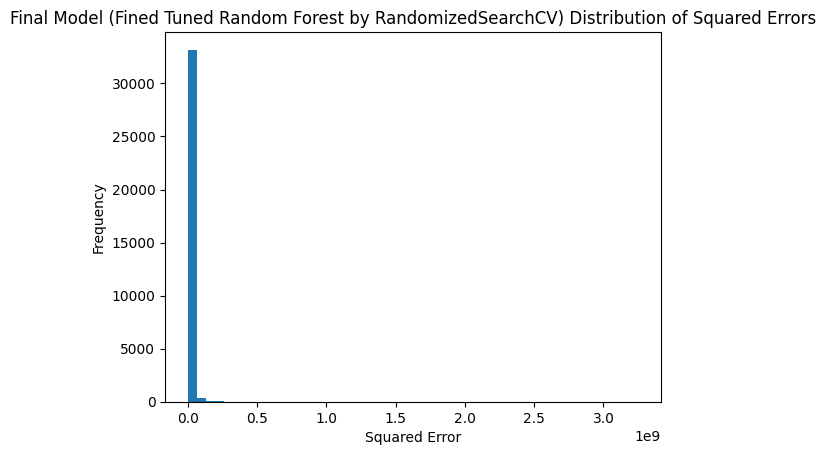

In [79]:
plt.hist(final_model_squared_errors, bins=50)
plt.title('Final Model (Fined Tuned Random Forest by RandomizedSearchCV) Distribution of Squared Errors')
plt.xlabel('Squared Error')
plt.ylabel('Frequency')
plt.show()

Let's view our biggest errors by getting our top 1% outliers of our squared errors.

In [80]:
outliers = df_final_model_squared_errors[df_final_model_squared_errors['Squared Errors'] > df_final_model_squared_errors['Squared Errors'].quantile(0.99)] 
print(outliers)

         Predictions   Actual  Squared Errors
775     44582.750833  53939.0    8.753940e+07
3987    69231.832917  60187.0    8.180900e+07
5335    42142.008333  51288.0    8.364916e+07
6780    21146.022500  31540.0    1.080348e+08
7249    38944.222083  53980.0    2.260746e+08
...              ...      ...             ...
394296  42530.370833  52180.0    9.311534e+07
395754  70046.109583  84794.0    2.175003e+08
396483  43690.019583  55475.0    1.388858e+08
396597  66033.677500  76095.0    1.012302e+08
398238  26857.134583  15990.0    1.180946e+08

[337 rows x 3 columns]


Let's view the 95% confidence interval of our RMSE

In [81]:
confidence = 0.95

np.sqrt(stats.t.interval(confidence, len(final_model_squared_errors)-1,
                         loc=final_model_squared_errors.mean(),
                         scale=stats.sem(final_model_squared_errors)))


array([2674.45399539, 2820.25037764])

# **Saving Our Final Model Using joblib**

We want to save our final model, but also save our original columns that we use in the model, our transformation pipeline, and a sample of the data we used to train. 

In [ ]:
column_summary = {}

for col in X_train.columns:
    col_data = X_train[col]  
    
    if pd.api.types.is_numeric_dtype(col_data):  
        column_summary[col] = {
            "dtype": col_data.dtype,
            "min": col_data.min(),
            "max": col_data.max(),
        }
    
    else: 
        column_summary[col] = {
            "dtype": col_data.dtype,
            "unique_values": col_data.unique().tolist()  
        }

data_sample = X_train.sample(n=500, random_state=42)
data_sample["price"] = y_train.loc[data_sample.index]  

# Saving our model, pipeline, columns, and sample data
UC_Price_Predictor = {
    "full_pipeline": full_pipeline, 
    "column_summary": column_summary, 
    "model": final_model, 
    "data_sample": data_sample
}

joblib.dump(UC_Price_Predictor, "UC_Price_Predictor.pkl")

['UC_Price_Predictor.pkl']